In [2]:
# utility modules
import glob
import os
import sys
import re
import io

# the usual suspects
import numpy as np
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import matplotlib.image as mpimg

# modules you'll need if you're downloading the data
from icepyx import icesat2data as ipd
import shutil
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon

import fiona
import pyproj
import h5py

# # run matplotlib in 'widget' mode
# %matplotlib widget
# %load_ext autoreload
# %autoreload 2

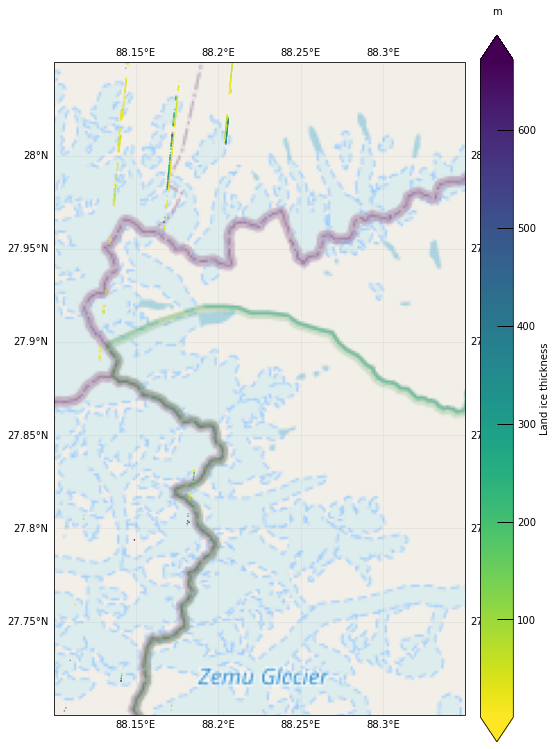

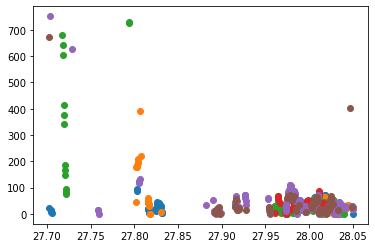

In [3]:
from readers.read_HDF5_ATL06 import atl06_to_dict

ATL06_file = 'ATL06_20190128163325_04770206_003_01.h5'
beam = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']
D6 = {}
for i in beam:
    D6[i] = {}
    data = atl06_to_dict(ATL06_file, i, index=None, epsg=3031)
    ext = (data['longitude'][:]>88.1) & (data['longitude'][:]<88.35) & (data['latitude'][:]<28.05) & (data['latitude'][:]>27.7)
    D6[i]['lon'] = data['longitude'][ext]
    D6[i]['lat'] = data['latitude'][ext]
    D6[i]['h_normal'] = data['h_li'][ext]+data['geoid_h'][ext]
    D6[i]['thickness'] = data['h_li'][ext]+data['geoid_h'][ext]-data['dem_h'][ext]

    
extent = [88.1, 88.35, 27.7, 28.2]
request = cimgt.OSM()    
fig = plt.figure(figsize=(9, 13))
ax = plt.axes(projection=request.crs)
cmap = cm.viridis_r
cmap.set_bad(alpha=0.0)
for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
    flag = (D6[gtx]['thickness'][:]>0) & (D6[gtx]['thickness'][:]<1000)
    sc = ax.scatter(D6[gtx]['lon'][flag],D6[gtx]['lat'][flag],
        c=D6[gtx]['thickness'][flag], s=0.1, cmap=cmap, transform=ccrs.PlateCarree())  
cbar = fig.colorbar(sc,ax=ax,extend='both',extendfrac=0.0375, pad=0.03, drawedges=False)
cbar.solids.set_rasterized(True)
cbar.ax.tick_params(which='both', length=16, width=1, direction='in')
cbar.ax.set_ylabel('Land ice thickness')
cbar.ax.set_xlabel('m')
cbar.ax.xaxis.set_label_coords(0.50,1.04)      
gl = ax.gridlines(draw_labels=True, alpha=0.2)
# gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_extent(extent)
ax.add_image(request, 10)
plt.show()


for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
    flag = (D6[gtx]['thickness'][:]>0) & (D6[gtx]['thickness'][:]<1000)
    y = plt.scatter(D6[gtx]['lat'][flag],D6[gtx]['thickness'][flag])
plt.show()

In [13]:
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# kml data
glacier_filepath = os.getcwd()+'/sikkimglaciers.kml'
gdfg = gpd.read_file(glacier_filepath) #GeoDataFrame object


mask = gdfg.geometry.unary_union
D6 = {} 
for i in beam:
    D6[i] = {}
    data = atl06_to_dict(ATL06_file, i, index=None, epsg=3031)
    flag = np.zeros(data['longitude'].size, dtype=bool)
    for j in range(0,data['longitude'].size):
        flag[j] = Point(data['longitude'][j],data['latitude'][j]).within(mask) 
    D6[i]['lon'] = data['longitude'][flag]
    D6[i]['lat'] = data['latitude'][flag]
    D6[i]['h_normal'] = data['h_li'][flag]+data['geoid_h'][flag]
    D6[i]['thickness'] = data['h_li'][flag]+data['geoid_h'][flag]-data['dem_h'][flag]

shapely.geometry.collection.GeometryCollection

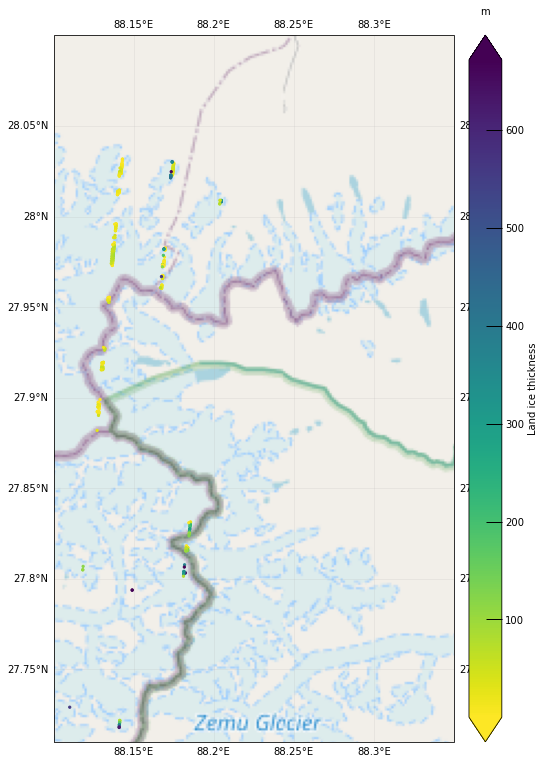

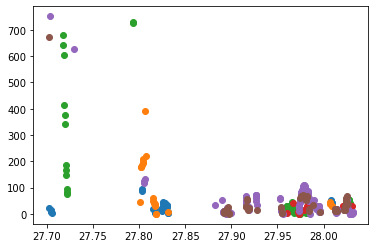

In [42]:
extent = [88.1, 88.35, 27.71, 28.1]
request = cimgt.OSM()    
fig = plt.figure(figsize=(9, 13))
ax = plt.axes(projection=request.crs)
cmap = cm.viridis_r
cmap.set_bad(alpha=0.0)
for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
    flag = (D6[gtx]['thickness'][:]>0) & (D6[gtx]['thickness'][:]<1000)
    sc = ax.scatter(D6[gtx]['lon'][flag],D6[gtx]['lat'][flag],
        c=D6[gtx]['thickness'][flag], s=5, cmap=cmap, transform=ccrs.PlateCarree())  
cbar = fig.colorbar(sc,ax=ax,extend='both',extendfrac=0.0375, pad=0.03, drawedges=False)
cbar.solids.set_rasterized(True)
cbar.ax.tick_params(which='both', length=16, width=1, direction='in')
cbar.ax.set_ylabel('Land ice thickness')
cbar.ax.set_xlabel('m')
cbar.ax.xaxis.set_label_coords(0.50,1.04)      
gl = ax.gridlines(draw_labels=True, alpha=0.2)
# gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_extent(extent)
ax.add_image(request, 10)
plt.show()


for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
    flag = (D6[gtx]['thickness'][:]>0) & (D6[gtx]['thickness'][:]<1000)
    y = plt.scatter(D6[gtx]['lat'][flag],D6[gtx]['thickness'][flag])
plt.show()  